In [1]:
!pip install -q wandb pytorch-lightning==2.0.0 torchmetrics torchvision
from google.colab import drive
drive.mount('/content/drive')

import wandb, torch, os
print("GPU:", torch.cuda.get_device_name(0))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU: Tesla T4


In [2]:
# paths
DATA_DIR = "/content/drive/MyDrive/processed_data"   # change if needed
CHECKPOINT_DIR = "/content/drive/MyDrive/resnet_sweeps"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

PROJECT = "inaturalist12k-resnet"
ENTITY = None    # set your wandb entity if needed

# basic defaults (sweep will override these)
cfg = {
    'learning_rate': 1e-4,
    'backbone_lr': 1e-5,
    'head_lr': 1e-3,
    'batch_size': 32,
    'max_epochs': 20,
    'weight_decay': 1e-4,
    'dropout': 0.5,
    'head_hidden': 512,
    'freeze_backbone': True,
    'unfreeze_after_epochs': 5,
    'unfreeze_last_n': 2,
    'augment': True,
    'early_stop_patience': 5,
    'fp16': True,
}


In [3]:
import time
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class INatDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=4, augment=True):
        super().__init__()
        self.data_dir, self.batch_size, self.num_workers, self.augment = data_dir, batch_size, num_workers, augment
        self.mean, self.std = [0.485,0.456,0.406], [0.229,0.224,0.225]

    def setup(self, stage=None):
        train_tf = []
        if self.augment:
            train_tf += [
                T.RandomResizedCrop(224),
                T.RandomHorizontalFlip(),
                T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
                T.RandomRotation(10),
            ]
        else:
            train_tf += [T.Resize(256), T.CenterCrop(224)]
        train_tf += [T.ToTensor(), T.Normalize(self.mean, self.std)]
        self.train_ds = datasets.ImageFolder(f"{self.data_dir}/train", transform=T.Compose(train_tf))
        self.val_ds   = datasets.ImageFolder(f"{self.data_dir}/val",   transform=T.Compose([
            T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(self.mean, self.std)]))
        self.test_ds  = datasets.ImageFolder(f"{self.data_dir}/test",  transform=T.Compose([
            T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(self.mean, self.std)]))
        self.num_classes = len(self.train_ds.classes)

    def train_dataloader(self): return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True,  num_workers=self.num_workers)
    def val_dataloader(self):   return DataLoader(self.val_ds,   batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    def test_dataloader(self):  return DataLoader(self.test_ds,  batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [4]:
import torch.nn as nn, torchvision.models as models
from torchmetrics.classification import MulticlassAccuracy
from pytorch_lightning import LightningModule

class ResNetFineTune(LightningModule):
    def __init__(self, cfg, num_classes):
        super().__init__()
        self.save_hyperparameters(cfg)
        self.cfg, self.num_classes = cfg, num_classes

        self.model = models.resnet50(pretrained=True)
        in_f = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(cfg['dropout']),
            nn.Linear(in_f, cfg['head_hidden']),
            nn.ReLU(),
            nn.Dropout(cfg['dropout']*0.6),
            nn.Linear(cfg['head_hidden'], num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)

        if cfg['freeze_backbone']: self.freeze_backbone()
        self._unfroze = False

    def freeze_backbone(self):
        for n,p in self.model.named_parameters():
            if 'fc' not in n: p.requires_grad=False

    def unfreeze_partial(self):
        layers = ['layer3','layer4']
        for n,p in self.model.named_parameters():
            if any(n.startswith(l) for l in layers) or 'fc' in n:
                p.requires_grad=True
        self._unfroze=True
        print("Unfroze last 2 ResNet blocks")

    def forward(self,x): return self.model(x)

    def configure_optimizers(self):
        head_lr = self.cfg['head_lr']; backbone_lr = self.cfg['backbone_lr']
        head, back = [], []
        for n,p in self.model.named_parameters():
            if p.requires_grad:
                (head if 'fc' in n else back).append(p)
        opt = torch.optim.AdamW([
            {'params': head, 'lr': head_lr},
            {'params': back, 'lr': backbone_lr}
        ], weight_decay=self.cfg['weight_decay'])
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.cfg['max_epochs'])
        return {"optimizer": opt, "lr_scheduler": sch}

    def training_step(self,batch,idx):
        x,y=batch; out=self(x); loss=self.loss_fn(out,y)
        self.train_acc.update(out.argmax(1),y)
        self.log_dict({'train_loss':loss,'train_acc':self.train_acc},on_epoch=True,prog_bar=True)
        return loss

    def validation_step(self,batch,idx):
        x,y=batch; out=self(x); loss=self.loss_fn(out,y)
        self.val_acc.update(out.argmax(1),y)
        self.log_dict({'val_loss':loss,'val_acc':self.val_acc},on_epoch=True,prog_bar=True)

    def on_train_epoch_end(self):
        if (not self._unfroze) and (self.current_epoch+1)>=self.cfg['unfreeze_after_epochs']:
            self.unfreeze_partial()


In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

wandb.login()
logger = WandbLogger(project=PROJECT, entity=ENTITY, config=cfg)

data_module = INatDataModule(DATA_DIR, batch_size=cfg['batch_size'], augment=cfg['augment'])
data_module.setup()

model = ResNetFineTune(cfg, num_classes=data_module.num_classes)

ckpt_cb = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR, monitor="val_acc", mode="max", save_top_k=1,
    filename="resnet50-{epoch:02d}-{val_acc:.4f}"
)
es_cb = EarlyStopping(monitor="val_acc", mode="max", patience=cfg['early_stop_patience'])
lr_cb = LearningRateMonitor(logging_interval='step')

trainer = Trainer(
    logger=logger,
    callbacks=[ckpt_cb, es_cb, lr_cb],
    max_epochs=cfg['max_epochs'],
    precision=16 if cfg['fp16'] else 32,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
)

trainer.fit(model, data_module)
print("Best checkpoint:", ckpt_cb.best_model_path)
wandb.finish()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: me21b118 (me21b118-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 78.1MB/s]
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Unfroze last 2 ResNet blocks


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Best checkpoint: /content/drive/MyDrive/resnet_sweeps/resnet50-epoch=14-val_acc=0.8145.ckpt


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
lr-AdamW/pg1,████████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
lr-AdamW/pg2,██████████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁
train_acc_epoch,▁▅▅▅▆▆▇▆▇▇▇▇█▇▇█████
train_loss_epoch,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_loss_step,▄█▇▆▅▆█▅▅▃▆▅▄▄▅▄▄▅▃▆▅▅▃▅▅▄▂▄▄▂▂▄▂▁▅▆▃▂▄▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
val_acc,▁▁▂▄▄▆▅▆▇▆▆▇▇▇█▇█▇▇▇
val_loss,█▇▆▄▄▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,19
lr-AdamW/pg1,1e-05


In [6]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'distribution':'log_uniform_values','min':1e-5,'max':1e-3},
        'backbone_lr':   {'distribution':'log_uniform_values','min':1e-6,'max':1e-4},
        'head_lr':       {'distribution':'log_uniform_values','min':1e-4,'max':5e-3},
        'weight_decay':  {'values':[1e-5,1e-4,1e-3]},
        'dropout':       {'values':[0.3,0.4,0.5]},
        'freeze_backbone': {'values':[True,False]},
        'unfreeze_after_epochs': {'values':[3,5,8]},
        'unfreeze_last_n': {'values':[1,2]},
        'augment': {'values':[True,False]},
        'batch_size': {'values':[16,32]},
        'max_epochs': {'values':[10,15,20]},
        'early_stop_patience': {'values':[3,5]}
    }
}
sweep_id = wandb.sweep(sweep_config, project=PROJECT)
print("Sweep ID:", sweep_id)

Create sweep with ID: jqrzgv2e
Sweep URL: https://wandb.ai/me21b118-iit-madras/inaturalist12k-resnet/sweeps/jqrzgv2e
Sweep ID: jqrzgv2e


In [ ]:
!wandb agent <your_sweep_id>

In [7]:
# ======================================
# ✅ TESTING PHASE
# ======================================

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchmetrics.classification import MulticlassAccuracy
from collections import defaultdict

# ---- Paths ----
CHECKPOINT_PATH = "/content/drive/MyDrive/resnet_sweeps/resnet50-epoch=14-val_acc=0.8145.ckpt"  # 🔁 update this
DATA_DIR = "/content/drive/MyDrive/processed_data"  # your dataset path

# ---- Load the trained model ----
best_model = ResNetFineTune.load_from_checkpoint(
    CHECKPOINT_PATH,
    cfg=cfg,
    num_classes=len(os.listdir(os.path.join(DATA_DIR, "train")))
)
best_model.eval()
best_model.to("cuda")

# ---- Prepare test dataset ----
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
test_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])
test_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=cfg['batch_size'], shuffle=False, num_workers=2)

# ---- Evaluate accuracy ----
acc_metric = MulticlassAccuracy(num_classes=len(test_ds.classes)).to("cuda")

best_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        preds = best_model(x).argmax(1)
        acc_metric.update(preds, y)

test_acc = acc_metric.compute().item()
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# ---- Optional: Per-class accuracy ----
class_correct = defaultdict(int)
class_total = defaultdict(int)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        preds = best_model(x).argmax(1)
        for label, pred in zip(y, preds):
            class_total[label.item()] += 1
            if label == pred:
                class_correct[label.item()] += 1

print("\nPer-class accuracies:")
for idx, cls in enumerate(test_ds.classes):
    acc = 100 * class_correct[idx] / class_total[idx]
    print(f"{cls:20s}: {acc:.2f}%")


✅ Test Accuracy: 81.40%

Per-class accuracies:
Amphibia            : 84.00%
Animalia            : 76.00%
Arachnida           : 85.50%
Aves                : 87.00%
Fungi               : 81.00%
Insecta             : 76.50%
Mammalia            : 83.50%
Mollusca            : 81.00%
Plantae             : 80.00%
Reptilia            : 79.50%


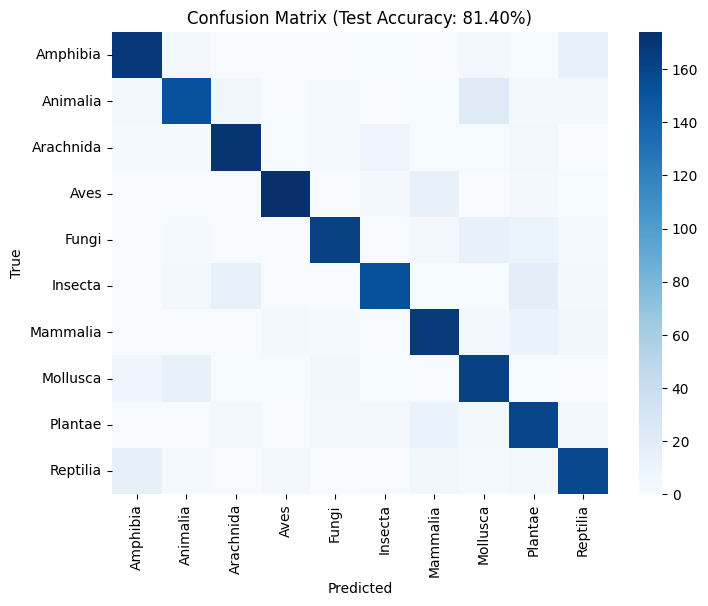

In [8]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm_metric = ConfusionMatrix(num_classes=len(test_ds.classes), task="multiclass").to("cuda")
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        preds = best_model(x).argmax(1)
        cm_metric.update(preds, y)

cm = cm_metric.compute().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, xticklabels=test_ds.classes, yticklabels=test_ds.classes,
            annot=False, cmap="Blues", cbar=True)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
